<a href="https://colab.research.google.com/github/mjr2010/FinCrimes_Narrative_Generator_simulation/blob/main/FinCrimes_Full_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# FinCrimes Narrative Generator — Full Project Notebook (EFTR & SWIFT Edition)

This notebook is a **complete, end-to-end demo project** for a FinCrime / AML portfolio:

- Generates a **synthetic banking dataset**:
  - Customers, accounts
  - Transactions including EFTR, SWIFT, DOMESTIC_EFT, CRD, etc.
  - SWIFT details and EFTR-like report rows
- Aggregates activity into **case-level features**
- Trains a **RandomForest risk model** on cases
- Builds **visuals**:
  - Correlation heatmap of features
  - Feature importance bar chart
- Implements 3 advanced functions:
  1. `detect_structuring_patterns` — detects near-threshold outgoing transactions in short time windows
  2. `find_similar_cases` — finds similar cases based on feature similarity
  3. `plot_case_activity_timeline` — visual timeline of inflows/outflows
- Adds a **template-based narrative generator** (no API needed)
- Provides optional **LLM integration** via OpenAI for regulator-style narratives

> You can run this notebook directly in **Google Colab** or locally with Python 3, pandas, scikit-learn, and matplotlib.


In [13]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import uuid
from datetime import datetime, date, timedelta
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics.pairwise import cosine_similarity

# For saving model
import joblib

# Set data directory (works in Colab or locally)
DATA_DIR = Path("/content/fincrimes_demo") if "/content" in os.getcwd() else Path("./fincrimes_demo")
DATA_DIR.mkdir(parents=True, exist_ok=True)

print("Using data directory:", DATA_DIR)


Using data directory: /content/fincrimes_demo


# 1. Generate Synthetic data

In [14]:

# -----------------------------
# 1. SYNTHETIC DATA GENERATION
# -----------------------------

# Parameters
n_customers = 200
n_accounts = 260
n_txns = 3000

start_date = date(2024, 1, 1)
end_date = date(2025, 10, 31)
days_span = (end_date - start_date).days

countries = ["CA","US","AE","HK","CY","KY","GB","IN","CN","NG"]
high_risk_countries = {"AE","CY","KY","NG"}

rng = np.random.default_rng(42)

# 1.1 Customers
customers = []
for i in range(n_customers):
    cust_id = f"CUST_{i+1:04d}"
    cust_type = rng.choice(["Individual","Business"], p=[0.8, 0.2])
    risk_rating = rng.choice(["Low","Medium","High"], p=[0.7, 0.2, 0.1])
    residency = rng.choice(countries, p=[0.5,0.2,0.05,0.04,0.03,0.02,0.05,0.05,0.03,0.03])
    kyc_flags = []
    if rng.random() < 0.05:
        kyc_flags.append("PEP")
    if rng.random() < 0.03:
        kyc_flags.append("AdverseMedia")
    onboard_dt = start_date + timedelta(days=int(rng.integers(0, 600)))
    customers.append({
        "customer_id": cust_id,
        "customer_type": cust_type,
        "risk_rating": risk_rating,
        "residency_country": residency,
        "kyc_flags": "|".join(kyc_flags),
        "onboard_date": onboard_dt.isoformat()
    })

customers_df = pd.DataFrame(customers)
customers_df.to_csv(DATA_DIR / "customers.csv", index=False)

# 1.2 Accounts
accounts = []
for i in range(n_accounts):
    acc_id = f"ACC_{i+1:04d}"
    cust = customers_df.sample(1, random_state=int(rng.integers(0, 1e9))).iloc[0]
    acc_type = rng.choice(["Chequing","Savings","Business","CRD"], p=[0.6,0.15,0.15,0.1])
    branch_country = rng.choice(countries, p=[0.6,0.15,0.05,0.04,0.03,0.02,0.04,0.03,0.02,0.02])
    accounts.append({
        "account_id": acc_id,
        "customer_id": cust.customer_id,
        "account_type": acc_type,
        "branch_country": branch_country,
        "status": "Active"
    })

accounts_df = pd.DataFrame(accounts)
accounts_df.to_csv(DATA_DIR / "accounts.csv", index=False)

# 1.3 Transactions, SWIFT details, EFTR reports
txns = []
swift_rows = []
eftr_rows = []

for i in range(n_txns):
    txn_id = f"TXN_{i+1:06d}"
    acc = accounts_df.sample(1, random_state=int(rng.integers(0, 1e9))).iloc[0]
    txn_date = start_date + timedelta(days=int(rng.integers(0, days_span+1)))

    channel = rng.choice(
        ["EFTR_OUT","EFTR_IN","SWIFT_MT103","SWIFT_MT202","DOMESTIC_EFT","CRD_POS","CRD_ADVANCE","INTERNAL_TRANSFER"],
        p=[0.12,0.12,0.12,0.02,0.30,0.18,0.04,0.10]
    )
    direction = "OUT" if channel in ["EFTR_OUT","SWIFT_MT103","SWIFT_MT202","CRD_ADVANCE","INTERNAL_TRANSFER"] else "IN"

    # amount distributions
    if channel.startswith("CRD"):
        amount = float(np.round(rng.uniform(10, 1500), 2))
    elif channel.startswith("EFTR") or channel.startswith("SWIFT"):
        base = rng.choice([500,1000,2500,5000,10000,25000,50000])
        amount = float(np.round(rng.exponential(scale=1.0)*base + rng.uniform(-100,100), 2))
        amount = max(10, min(amount, 1000000))
    else:
        amount = float(np.round(rng.uniform(5,20000), 2))

    counterparty_country = rng.choice(countries, p=[0.6,0.15,0.05,0.04,0.03,0.02,0.04,0.03,0.02,0.02])

    txns.append({
        "txn_id": txn_id,
        "account_id": acc.account_id,
        "channel": channel,
        "direction": direction,
        "amount": amount,
        "currency": "CAD",
        "txn_date": txn_date.isoformat(),
        "counterparty_country": counterparty_country
    })

    # SWIFT details
    if channel in ["SWIFT_MT103","SWIFT_MT202"]:
        field_59 = rng.choice(["ABC General Trading LLC","Omega Importers","Private Client","No Name Co","Acme Holdings"])
        field_56_country = rng.choice(countries)
        field_70 = rng.choice(["Consulting services","Invoice payment","Loan repayment","Investment","Gift"])
        swift_rows.append({
            "txn_id": txn_id,
            "field_20": str(uuid.uuid4())[:12],
            "field_23B": "CRED",
            "field_32A": txn_date.isoformat(),
            "field_50": "Ordering Customer",
            "field_56_country": field_56_country,
            "field_57": "AcctWith",
            "field_59": field_59,
            "field_70": field_70,
            "field_72": ""
        })

    # EFTR reports for EFTR channels above a minimum
    if channel in ["EFTR_OUT","EFTR_IN"] and amount >= 1000:
        report_type = "OUT" if channel == "EFTR_OUT" else "IN"
        originator_country = "CA" if direction == "IN" else rng.choice(countries)
        beneficiary_country = rng.choice(countries)
        eftr_rows.append({
            "eftr_id": f"EFTR_{len(eftr_rows)+1:05d}",
            "txn_id": txn_id,
            "report_type": report_type,
            "reported_amount": amount,
            "originator_country": originator_country,
            "beneficiary_country": beneficiary_country,
            "originator_name": f"Origin {rng.integers(1,500)}",
            "beneficiary_name": f"Benef {rng.integers(1,500)}"
        })

txns_df = pd.DataFrame(txns)
txns_df.to_csv(DATA_DIR / "transactions.csv", index=False)
pd.DataFrame(swift_rows).to_csv(DATA_DIR / "swift_details.csv", index=False)
pd.DataFrame(eftr_rows).to_csv(DATA_DIR / "eftr_reports.csv", index=False)



In [15]:
customers_df.head(), accounts_df.head(), txns_df.head()

(  customer_id customer_type risk_rating residency_country kyc_flags  \
 0   CUST_0001    Individual         Low                GB             
 1   CUST_0002    Individual      Medium                CA             
 2   CUST_0003      Business         Low                KY             
 3   CUST_0004    Individual      Medium                US             
 4   CUST_0005      Business      Medium                HK             
 
   onboard_date  
 0   2024-11-11  
 1   2025-08-08  
 2   2024-02-25  
 3   2024-11-28  
 4   2024-10-25  ,
   account_id customer_id account_type branch_country  status
 0   ACC_0001   CUST_0180     Chequing             AE  Active
 1   ACC_0002   CUST_0071     Business             CA  Active
 2   ACC_0003   CUST_0003     Chequing             NG  Active
 3   ACC_0004   CUST_0003     Chequing             CA  Active
 4   ACC_0005   CUST_0144      Savings             IN  Active,
        txn_id account_id       channel direction    amount currency  \
 0  TXN_0000

# 2. Aggregation
Here we club together for a particular customer and for each account how many Files were generated till date so far.
In this notebook, the case-aggregation cell indicates as:
1.   Combines all transacions belonging to one account
2.   Calculates summary metrics (volume, frequency, number of countries, etc)
3.   Stores which rules triggered that suspicion(rule_hits).





In [16]:

# -----------------------------
# 2. CASE AGGREGATION
# -----------------------------

# Aggregate transactions at "case" level.
# For demo, we define each account_id as one case_id.

transactions = pd.read_csv(DATA_DIR / "transactions.csv")
accounts_df = pd.read_csv(DATA_DIR / "accounts.csv")

cases = []
case_txn_rows = []

for acc_id, group in transactions.groupby("account_id"):
    # For simplicity, treat the whole history as the window
    group = group.sort_values("txn_date")
    num_txn = len(group)
    num_eftr = group[group["channel"].str.contains("EFTR")].shape[0]
    num_swift = group[group["channel"].str.contains("SWIFT")].shape[0]
    total_out = group[group["direction"]=="OUT"]["amount"].sum()
    total_in = group[group["direction"]=="IN"]["amount"].sum()
    num_countries = group["counterparty_country"].nunique()

    case_id = f"CASE_{acc_id.split('_')[-1]}"

    # Simple rule-based suspicious label
    label = 0
    rule_hits = []
    if num_eftr >= 3 and total_out > 20000:
            label = 1
            rule_hits.append("RULE_STRUCTURING_EFTR_HIGH_VOLUME")
    if num_swift >= 2 and num_countries >= 3:
            label = 1
            rule_hits.append("RULE_SWIFT_MULTIPLE_CORRIDORS")
    if (group["direction"]=="OUT").sum() >= 10 and total_out > 50000:
            label = 1
            rule_hits.append("RULE_RAPID_OUTFLOWS")

    cases.append({
            "case_id": case_id,
            "primary_account_id": acc_id,
            "num_txn": num_txn,
            "num_eftr": num_eftr,
            "num_swift": num_swift,
            "total_out": total_out,
            "total_in": total_in,
            "num_countries": num_countries,
            "label": label,
            "rule_hits": "|".join(rule_hits)
        })

    for _, r in group.iterrows():
            case_txn_rows.append({
                "case_id": case_id,
                "txn_id": r["txn_id"],
                "channel": r["channel"],
                "amount": r["amount"],
                "txn_date": r["txn_date"],
                "counterparty_country": r["counterparty_country"]
            })

    cases_df = pd.DataFrame(cases)
    case_txns_df = pd.DataFrame(case_txn_rows)

    cases_df.to_csv(DATA_DIR / "cases.csv", index=False)
    case_txns_df.to_csv(DATA_DIR / "case_transactions.csv", index=False)

    cases_df.head()


In [17]:
cases_df.head()


,case_id,primary_account_id,num_txn,num_eftr,num_swift,total_out,total_in,num_countries,label,rule_hits
0,CASE_0001,ACC_0001,7,4,0,82219.58,12796.87,3,1,RULE_STRUCTURING_EFTR_HIGH_VOLUME
1,CASE_0002,ACC_0002,13,4,2,104993.42,53508.89,5,1,RULE_STRUCTURING_EFTR_HIGH_VOLUME|RULE_SWIFT_M...
2,CASE_0003,ACC_0003,7,2,3,23466.67,22596.67,5,1,RULE_SWIFT_MULTIPLE_CORRIDORS
3,CASE_0004,ACC_0004,6,3,2,306110.57,29327.89,2,1,RULE_STRUCTURING_EFTR_HIGH_VOLUME
4,CASE_0005,ACC_0005,14,1,0,40708.09,64073.72,5,0,


**What does Rule Hits mean:**
In real world, banks use automated monitoring systems to detect suspicious transactions. These systems run a set of predefined rules, similar to 'if-then' conditions, that look for unsual financial patterns.

For example:
*   Multiple **EFTR** transactions just under the $10,000 reporting limit---> RULE_STRUCTURING_EFTR_HIGH_VOLUME
*   Several **SWIFT** transfers to different countries--->RULE_SWIFT_MULTIPLE_CORRIDORS
*   Rapid outgoing transfers shortly after large long inflows--->RULE_RAPID_OUTFLOWS

In [5]:

# -----------------------------
# 3. RISK MODEL (RandomForest)
# -----------------------------

feature_cols = ["num_txn","num_eftr","num_swift","total_out","total_in","num_countries"]
X = cases_df[feature_cols].fillna(0)
y = cases_df["label"].fillna(0)

# If no positive labels, create synthetic ones just for demo
if y.sum() == 0:
    X_tmp = X.copy()
    X_tmp["synthetic_score"] = X_tmp["num_eftr"]*2 + X_tmp["num_swift"]*1.5 + (X_tmp["total_out"]/10000)
    y = (X_tmp["synthetic_score"] > 3).astype(int)
    X = X_tmp[feature_cols]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y if y.nunique()>1 else None
)

clf = RandomForestClassifier(n_estimators=150, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Classification report:\n")
print(classification_report(y_test, y_pred, zero_division=0))

# Feature importances
importances = pd.Series(clf.feature_importances_, index=feature_cols).sort_values(ascending=False)
print("\nFeature importances:")
print(importances)

joblib.dump(clf, DATA_DIR / "rf_model.joblib")
importances.to_csv(DATA_DIR / "feature_importances.csv")


Classification report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      1.00      1.00        42

    accuracy                           1.00        65
   macro avg       1.00      1.00      1.00        65
weighted avg       1.00      1.00      1.00        65


Feature importances:
num_swift        0.291895
total_out        0.288517
num_eftr         0.160876
num_txn          0.113798
num_countries    0.073665
total_in         0.071249
dtype: float64


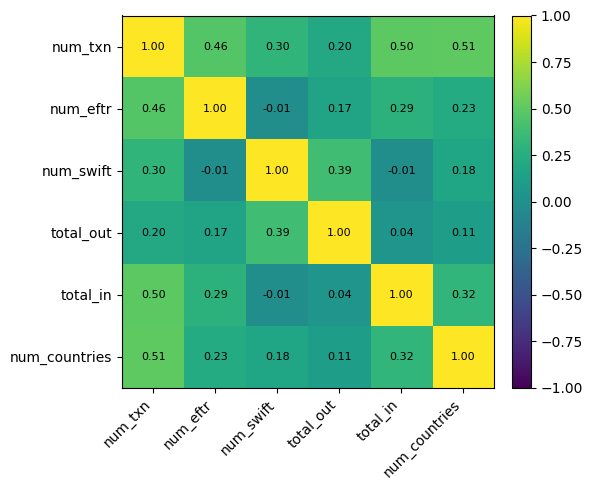

Saved correlation heatmap to: /content/fincrimes_demo/correlation_heatmap.png


/tmp/ipython-input-1361020584.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(importances.index, rotation=45, ha='right')


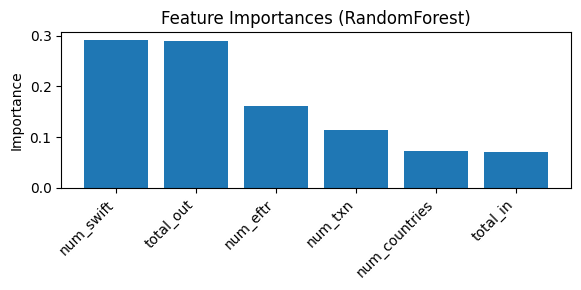

Saved feature importance plot to: /content/fincrimes_demo/feature_importance.png


In [6]:

# -----------------------------
# 4. VISUALISATIONS
# -----------------------------

plt.rcParams.update({'figure.max_open_warning': 0})

# 4.1 Correlation heatmap
corr = cases_df[feature_cols].corr()

fig1, ax1 = plt.subplots(figsize=(6,5))
cax = ax1.imshow(corr.values, interpolation='nearest', vmin=-1, vmax=1)
ax1.set_xticks(range(len(feature_cols)))
ax1.set_yticks(range(len(feature_cols)))
ax1.set_xticklabels(feature_cols, rotation=45, ha='right')
ax1.set_yticklabels(feature_cols)

for (i, j), val in np.ndenumerate(corr.values):
    ax1.text(j, i, f"{val:.2f}", ha='center', va='center', fontsize=8)

fig1.colorbar(cax, ax=ax1, fraction=0.046, pad=0.04)
fig1.tight_layout()
heatmap_path = DATA_DIR / "correlation_heatmap.png"
fig1.savefig(heatmap_path, dpi=150)
plt.show()

print("Saved correlation heatmap to:", heatmap_path)

# 4.2 Feature importance bar chart
fig2, ax2 = plt.subplots(figsize=(6,3))
ax2.bar(importances.index, importances.values)
ax2.set_title("Feature Importances (RandomForest)")
ax2.set_ylabel("Importance")
ax2.set_xticklabels(importances.index, rotation=45, ha='right')
fig2.tight_layout()
fi_path = DATA_DIR / "feature_importance.png"
fig2.savefig(fi_path, dpi=150)
plt.show()

print("Saved feature importance plot to:", fi_path)


In [7]:

# -----------------------------
# 5. STRUCTURING PATTERN DETECTOR
# -----------------------------

def detect_structuring_patterns(case_id: str,
                                threshold: float = 10000.0,
                                tolerance: float = 500.0,
                                window_days: int = 7,
                                min_txn_in_cluster: int = 3):
    """
    Detect potential structuring clusters for a given case_id.

    Logic (simple, explainable):
    - Consider OUTGOING transactions only.
    - Keep txns where amount is just below a threshold:
        threshold - tolerance <= amount < threshold
    - Within rolling time windows (window_days), identify groups with at least
      min_txn_in_cluster such txns.

    Returns:
        list[dict] of clusters:
        {
          "start_date": ...,
          "end_date": ...,
          "num_txn": ...,
          "total_amount": ...,
          "avg_amount": ...,
          "channels": [...],
          "countries": [...]
        }
    """
    tx = case_txns_df[case_txns_df["case_id"] == case_id].copy()
    if tx.empty:
        return []

    # Join direction information
    tx = tx.merge(transactions[["txn_id","direction"]], on="txn_id", how="left")

    # Outgoing only
    tx = tx[tx["direction"] == "OUT"].copy()
    if tx.empty:
        return []

    tx["txn_date"] = pd.to_datetime(tx["txn_date"])

    # Filter by near-threshold amount
    mask = (tx["amount"] >= (threshold - tolerance)) & (tx["amount"] < threshold)
    tx = tx[mask].sort_values("txn_date")
    if tx.empty:
        return []

    clusters = []
    for idx, row in tx.iterrows():
        start = row["txn_date"]
        end = start + timedelta(days=window_days)
        window_tx = tx[(tx["txn_date"] >= start) & (tx["txn_date"] <= end)]
        if len(window_tx) >= min_txn_in_cluster:
            clusters.append({
                "start_date": window_tx["txn_date"].min().date().isoformat(),
                "end_date": window_tx["txn_date"].max().date().isoformat(),
                "num_txn": int(len(window_tx)),
                "total_amount": float(window_tx["amount"].sum()),
                "avg_amount": float(window_tx["amount"].mean()),
                "channels": sorted(window_tx["channel"].unique().tolist()),
                "countries": sorted(window_tx["counterparty_country"].unique().tolist()),
            })

    # Deduplicate clusters
    unique = []
    seen = set()
    for c in clusters:
        key = (c["start_date"], c["end_date"], c["num_txn"], round(c["total_amount"], 2))
        if key not in seen:
            seen.add(key)
            unique.append(c)

    return unique

# Quick test
example_case_id = cases_df["case_id"].iloc[0]
print("Example case:", example_case_id)
print("Structuring clusters:", detect_structuring_patterns(example_case_id))


Example case: CASE_0001
Structuring clusters: []


In [8]:

# -----------------------------
# 6. CASE SIMILARITY SEARCH
# -----------------------------

SIM_FEATURE_COLS = ["num_txn","num_eftr","num_swift","total_out","total_in","num_countries"]

def find_similar_cases(target_case_id: str, top_k: int = 5):
    """
    Find top_k most similar cases to target_case_id based on numeric features
    using cosine similarity.

    Returns:
        DataFrame with case_id, similarity_score, and feature columns.
    """
    if target_case_id not in cases_df["case_id"].values:
        raise ValueError(f"{target_case_id} not found in cases_df['case_id'].")

    feat_df = cases_df[["case_id"] + SIM_FEATURE_COLS].dropna().reset_index(drop=True)

    target_row = feat_df[feat_df["case_id"] == target_case_id]
    if target_row.empty:
        raise ValueError(f"No feature row found for case_id {target_case_id}.")
    target_vec = target_row[SIM_FEATURE_COLS].values

    others = feat_df[feat_df["case_id"] != target_case_id].copy()
    if others.empty:
        return pd.DataFrame()

    other_vecs = others[SIM_FEATURE_COLS].values

    sims = cosine_similarity(target_vec, other_vecs)[0]
    others["similarity_score"] = sims

    # Attach label if available
    if "label" in cases_df.columns:
        others = others.merge(cases_df[["case_id","label"]], on="case_id", how="left")

    result = others.sort_values("similarity_score", ascending=False).head(top_k)
    return result[["case_id","similarity_score"] + SIM_FEATURE_COLS + (["label"] if "label" in cases_df.columns else [])]

# Quick test
similar_df = find_similar_cases(example_case_id, top_k=5)
print("Similar cases to", example_case_id)
print(similar_df)


Similar cases to CASE_0001
       case_id  similarity_score  num_txn  num_eftr  num_swift  total_out  \
178  CASE_0180          0.999989       11         2          3  174344.27   
40   CASE_0042          0.999952       12         2          3   67553.63   
98   CASE_0100          0.999940       15         7          2  180624.93   
32   CASE_0034          0.999775       10         3          0   96497.48   
170  CASE_0172          0.999553       13         2          3  321494.39   

     total_in  num_countries  label  
178  27988.16              3      1  
40   11191.44              3      1  
98   26098.04              4      1  
32   12928.58              4      1  
170  40236.69              6      1  


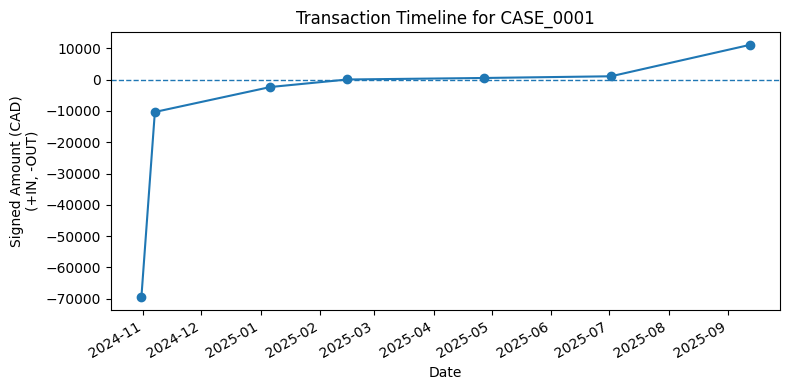

In [9]:

# -----------------------------
# 7. ACTIVITY TIMELINE PLOT
# -----------------------------

def plot_case_activity_timeline(case_id: str):
    """
    Plot a simple time-series of signed transaction amounts for a case:
    - IN flows: positive
    - OUT flows: negative
    """
    tx = case_txns_df[case_txns_df["case_id"] == case_id].copy()
    if tx.empty:
        raise ValueError(f"No transactions found for case_id {case_id}")

    tx = tx.merge(transactions[["txn_id","direction"]], on="txn_id", how="left")
    tx["txn_date"] = pd.to_datetime(tx["txn_date"])
    tx = tx.sort_values("txn_date")

    tx["signed_amount"] = np.where(tx["direction"]=="OUT", -tx["amount"], tx["amount"])

    fig, ax = plt.subplots(figsize=(8,4))
    ax.scatter(tx["txn_date"], tx["signed_amount"])
    ax.plot(tx["txn_date"], tx["signed_amount"])

    ax.axhline(0, linestyle="--", linewidth=1)
    ax.set_title(f"Transaction Timeline for {case_id}")
    ax.set_xlabel("Date")
    ax.set_ylabel("Signed Amount (CAD)\n(+IN, -OUT)")

    fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()

# Quick test
plot_case_activity_timeline(example_case_id)


In [10]:

# -----------------------------
# 8. TEMPLATE-BASED NARRATIVE GENERATOR
# -----------------------------

def generate_template_narrative(case_id: str):
    """
    Generate a simple narrative using:
    - case-level stats
    - a few recent transactions
    - detected structuring clusters
    - RandomForest risk score
    """
    case = cases_df[cases_df["case_id"] == case_id]
    if case.empty:
        raise ValueError(f"Unknown case_id {case_id}")
    case = case.iloc[0]

    # RF risk score
    feat = case[feature_cols].values.reshape(1, -1)
    risk_score = float(clf.predict_proba(feat)[0, 1])
    risk_bucket = "High" if risk_score > 0.6 else ("Medium" if risk_score > 0.35 else "Low")

    # Sample recent transactions
    tx = case_txns_df[case_txns_df["case_id"] == case_id].copy()
    tx["txn_date"] = pd.to_datetime(tx["txn_date"])
    tx = tx.sort_values("txn_date", ascending=False).head(5)

    tx_list_str = "; ".join([
        f"{row['txn_date'].date().isoformat()} {row['channel']} CAD {int(row['amount']):,} to {row['counterparty_country']}"
        for _, row in tx.iterrows()
    ])

    clusters = detect_structuring_patterns(case_id)
    clusters_str = "None identified"
    if clusters:
        parts = []
        for c in clusters:
            parts.append(
                f"{c['num_txn']} near-threshold txns totalling CAD {int(c['total_amount']):,} "
                f"between {c['start_date']} and {c['end_date']}"
            )
        clusters_str = "; ".join(parts)

    background = (
        f"Case {case_id} relates to primary account {case['primary_account_id']} with "
        f"{int(case['num_txn'])} transactions and counterparties in {int(case['num_countries'])} countries in the review period."
    )

    summary = (
        f"Total outgoing volume over the period is approximately CAD {int(case['total_out']):,}, "
        f"while incoming volume is approximately CAD {int(case['total_in']):,}. "
        f"The monitoring system flagged {int(case['num_eftr'])} EFTR events and {int(case['num_swift'])} SWIFT messages."
    )

    indicators = (
        f"The machine risk score for this case is {risk_score:.2f} ({risk_bucket}). "
        f"Rule-based indicators: {case['rule_hits'] if case['rule_hits'] else 'None'}. "
        f"Recent transactions include: {tx_list_str}. "
        f"Detected structuring clusters: {clusters_str}."
    )

    conclusion = (
        "Given the observed activity and the level of outbound volume relative to inbound flows, "
        "the case may warrant enhanced due diligence. If no legitimate economic rationale can be "
        "confirmed, an STR filing should be considered."
    )

    narrative = (
        "1) Background and Customer Profile\n" + background + "\n\n" +
        "2) Summary of Activity\n" + summary + "\n\n" +
        "3) Suspicious Indicators and EFTR/SWIFT Details\n" + indicators + "\n\n" +
        "4) Conclusion and Recommendation\n" + conclusion
    )

    return narrative, risk_score, risk_bucket

# Quick test
tmpl_narrative, tmpl_score, tmpl_bucket = generate_template_narrative(example_case_id)
print(tmpl_narrative[:800], "...\n\nRisk score:", tmpl_score, "Bucket:", tmpl_bucket)


1) Background and Customer Profile
Case CASE_0001 relates to primary account ACC_0001 with 7 transactions and counterparties in 3 countries in the review period.

2) Summary of Activity
Total outgoing volume over the period is approximately CAD 82,219, while incoming volume is approximately CAD 12,796. The monitoring system flagged 4 EFTR events and 0 SWIFT messages.

3) Suspicious Indicators and EFTR/SWIFT Details
The machine risk score for this case is 0.76 (High). Rule-based indicators: RULE_STRUCTURING_EFTR_HIGH_VOLUME. Recent transactions include: 2025-09-12 EFTR_IN CAD 11,106 to CA; 2025-07-02 CRD_POS CAD 1,087 to NG; 2025-04-27 DOMESTIC_EFT CAD 544 to CY; 2025-02-15 EFTR_IN CAD 58 to NG; 2025-01-06 EFTR_OUT CAD 2,347 to CY. Detected structuring clusters: None identified.

4) Conclus ...

Risk score: 0.76 Bucket: High


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(



## 9. Optional: LLM-Based Narrative Generator (OpenAI)

The following section shows how you can plug in an **LLM** (e.g., OpenAI GPT) to generate
more sophisticated narratives from the same case JSON.

> ⚠️ You need an OpenAI API key and the `openai` Python client installed.  
> Do **not** commit your API key into any public repo.


In [11]:
# Install client if needed (uncomment in Colab)
!pip install openai -q
print("OpenAI installed succesfully")

OpenAI installed succesfully


In [12]:
import os
import json
from openai import OpenAI

def init_openai_client():
    """Initialise OpenAI client using OPENAI_API_KEY env variable."""
    api_key = os.environ.get("OPENAI_API_KEY")
    if not api_key:
        raise RuntimeError("OPENAI_API_KEY is not set. Please set it before calling the LLM.")
    return OpenAI(api_key=api_key)

def build_case_json(case_id: str, top_n_txns: int = 5):
    """Build a compact JSON-like object for feeding to the LLM."""
    case_row = cases_df[cases_df["case_id"] == case_id]
    if case_row.empty:
        raise ValueError(f"case_id {case_id} not found")
    case_row = case_row.iloc[0]

    tx = case_txns_df[case_txns_df["case_id"] == case_id].copy()
    tx = tx.sort_values("txn_date", ascending=False).head(top_n_txns)

    # Join SWIFT and EFTR metadata
    swift_df = pd.read_csv(DATA_DIR / "swift_details.csv")
    eftr_df = pd.read_csv(DATA_DIR / "eftr_reports.csv")

    tx_full = tx.merge(transactions, on=["txn_id","channel","amount","txn_date","counterparty_country"], how="left")
    tx_full = tx_full.merge(swift_df, on="txn_id", how="left")
    tx_full = tx_full.merge(
        eftr_df[["txn_id","report_type","reported_amount","originator_country","beneficiary_country"]],
        on="txn_id", how="left"
    )

    key_txns = []
    for _, r in tx_full.iterrows():
        key_txns.append({
            "txn_id": r["txn_id"],
            "channel": r["channel"],
            "date": r["txn_date"],
            "amount": float(r["amount"]),
            "currency": "CAD",
            "counterparty_country": r["counterparty_country"],
            "direction": r["direction"],
            "eftr_report_type": r.get("report_type"),
            "eftr_originator_country": r.get("originator_country"),
            "eftr_beneficiary_country": r.get("beneficiary_country"),
            "swift_field_59": r.get("field_59"),
            "swift_field_56_country": r.get("field_56_country"),
            "swift_field_70": r.get("field_70"),
        })

    struct_clusters = detect_structuring_patterns(case_id)
    similar_cases = find_similar_cases(case_id, top_k=3)

    case_obj = {
        "case_id": case_id,
        "account": {"account_id": case_row["primary_account_id"]},
        "summary_stats": {
            "num_txn": int(case_row["num_txn"]),
            "num_eftr": int(case_row["num_eftr"]),
            "num_swift": int(case_row["num_swift"]),
            "total_out": float(case_row["total_out"]),
            "total_in": float(case_row["total_in"]),
            "num_countries": int(case_row["num_countries"]),
        },
        "risk": {
            "label": int(case_row["label"]),
            "rule_hits": case_row["rule_hits"],
        },
        "structuring_clusters": struct_clusters,
        "similar_cases": similar_cases.to_dict(orient="records"),
        "key_transactions": key_txns,
    }
    return case_obj

SYSTEM_PROMPT = """You are an AML investigator at a Canadian financial institution.
You write clear, factual, regulator-aligned narratives for suspicious transaction reports
based on EFTR, SWIFT, and domestic transaction data.

- Use a neutral, professional tone.
- Reference specific dates, amounts, channels, and countries where available.
- Explain why the activity is unusual versus expected customer behavior.
- Clearly connect EFTR and SWIFT activity to red flags (high-risk countries,
  intermediaries, structuring, rapid movement of funds, etc.).
- Incorporate the provided 'structuring_clusters' and 'similar_cases' information when relevant.
- Do not invent information that is not present in the case data.
- Structure the output into:
  1) Background and Customer Profile
  2) Summary of Activity
  3) Suspicious Indicators and EFTR/SWIFT Details
  4) Conclusion and Recommendation
"""

def generate_narrative_llm(case_id: str,
                           model: str = "gpt-4.1-mini",
                           max_output_tokens: int = 700):
    """Call OpenAI's Responses API to generate a narrative for the given case_id."""
    client = init_openai_client()
    case_obj = build_case_json(case_id)

    user_prompt = f"""Below is a JSON object describing a potential financi


    al crime case
that includes EFTR, SWIFT, and domestic transactions, as well as some pre-computed analytics.

JSON:
{json.dumps(case_obj, indent=2)}

Write a narrative suitable for an internal AML case summary or STR support document with:

- 250–350 words.
- The specified four headings.
- Explicit mention of EFTR and SWIFT activity when relevant.
- Reference structuring clusters and similar cases if they help explain risk.
- Only use the facts provided in the JSON. Do not add new names, banks, or amounts.
"""

    response = client.responses.create(
        model=model,
        input=[
            {"role": "system", "content": SYSTEM_PROMPT},
            {"role": "user", "content": user_prompt}
        ],
        max_output_tokens=max_output_tokens
    )

    # Extract narrative text from response.output (generic parsing)
    out_chunks = []
    for item in response.output:
        for c in item.content:
            text_val = getattr(c, "text", None)
            if text_val:
                out_chunks.append(text_val)

    narrative_text = "\n".join(out_chunks) if out_chunks else str(response)
    return narrative_text

#Example usage (uncomment after setting OPENAI_API_KEY):
#os.environ["OPENAI_API_KEY"] = "sk-..."  # or set externally
#example_case_id = cases_df["case_id"].iloc[0]
#llm_narr = generate_narrative_llm(example_case_id)
#print(llm_narr)


In [22]:
!pip install graphviz -qq
from graphviz import Digraph

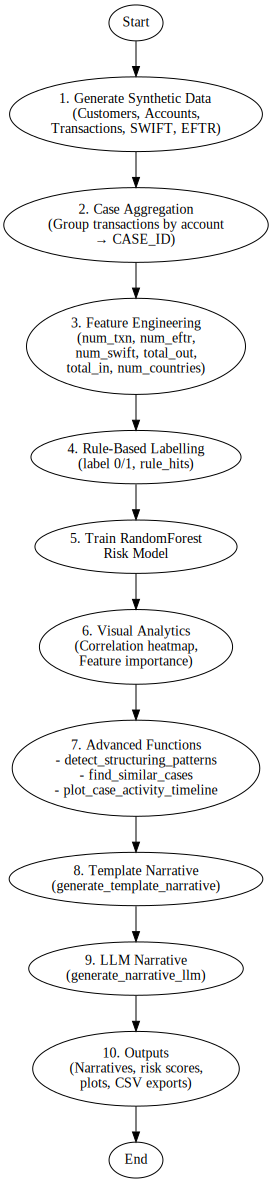

In [23]:
from graphviz import Digraph
dot = Digraph(comment="FinCrimes System Flowchart", format="png")
dot.attr(rankdir="TB", fontsize="10", fontname="Helvetica")

dot.node("A", "Start")
dot.node("B", "1. Generate Synthetic Data\n(Customers, Accounts,\nTransactions, SWIFT, EFTR)")
dot.node("C", "2. Case Aggregation\n(Group transactions by account\n→ CASE_ID)")
dot.node("D", "3. Feature Engineering\n(num_txn, num_eftr,\nnum_swift, total_out,\n total_in, num_countries)")
dot.node("E", "4. Rule-Based Labelling\n(label 0/1, rule_hits)")
dot.node("F", "5. Train RandomForest\nRisk Model")
dot.node("G", "6. Visual Analytics\n(Correlation heatmap,\nFeature importance)")
dot.node("H", "7. Advanced Functions\n- detect_structuring_patterns\n- find_similar_cases\n- plot_case_activity_timeline")
dot.node("I", "8. Template Narrative\n(generate_template_narrative)")
dot.node("J", "9. LLM Narrative\n(generate_narrative_llm)")
dot.node("K", "10. Outputs\n(Narratives, risk scores,\nplots, CSV exports)")
dot.node("L", "End")

dot.edges(["AB","BC","CD","DE","EF","FG","GH","HI","IJ","JK","KL"])
dot.render("fincrimes_flowchart", cleanup=True)
dot

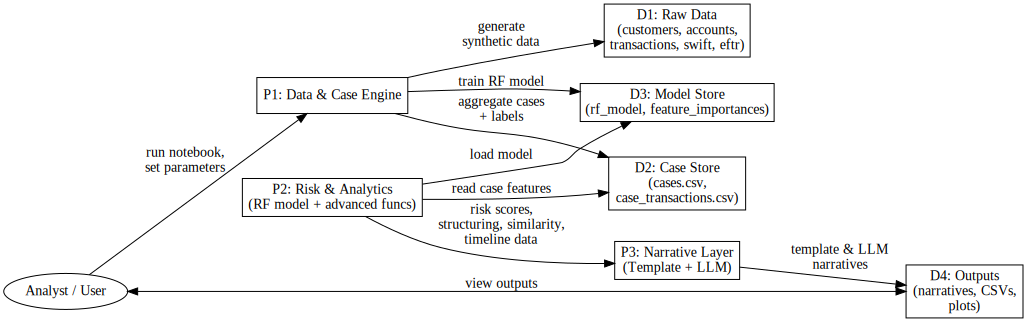

In [27]:
from graphviz import Digraph
dfd = Digraph(comment="FinCrimes DFD", format="png")
dfd.attr(rankdir="LR", fontsize="10", fontname="Helvetica")
# External entity
dfd.node("U", "Analyst / User", shape="oval")
# Processes
dfd.node("P1", "P1: Data & Case Engine", shape="box")
dfd.node("P2", "P2: Risk & Analytics\n(RF model + advanced funcs)", shape="box")
dfd.node("P3", "P3: Narrative Layer\n(Template + LLM)", shape="box")
# Data stores
dfd.node("D1", "D1: Raw Data\n(customers, accounts,\ntransactions, swift, eftr)", shape=" cylinder")
dfd.node("D2", "D2: Case Store\n(cases.csv,\ncase_transactions.csv)", shape=" cylinder")
dfd.node("D3", "D3: Model Store\n(rf_model, feature_importances)", shape=" cylinder")
dfd.node("D4", "D4: Outputs\n(narratives, CSVs,\nplots)", shape=" cylinder")
# Flows
dfd.edge("U", "P1", label="run notebook,\nset parameters")
dfd.edge("P1", "D1", label="generate\nsynthetic data")
dfd.edge("P1", "D2", label="aggregate cases\n+ labels")
dfd.edge("P1", "D3", label="train RF model")

dfd.edge("P2", "D2", label="read case features")
dfd.edge("P2", "D3", label="load model")
dfd.edge("P2", "P3", label="risk scores,\nstructuring, similarity,\ntimeline data")

dfd.edge("P3", "D4", label="template & LLM\nnarratives")
dfd.edge("U", "D4", label="view outputs", dir="both")

dfd.render("fincrimes_dfd", cleanup=True)
dfd